## Importing Packages

In [1]:
import numpy as np
import pandas as pd
import cmdstanpy 
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import os
import json

from scipy.stats import gaussian_kde
import ipywidgets as widgets

In [2]:
sns.set_theme(style="whitegrid")
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['pdf.use14corefonts'] = True

## Choose Model

#### roots

In [3]:
root = './'
plots_root = root + 'Plots/'
datasets_root = root + 'Datasets/'
behavioural_data_root = root +  'behavioral_data/selected_data/' 
stan_files_root = root +  'stan files/' 
saved_models_root = root + 'stan_results/'

model_config = {}
plots_path = ''
dataset_path = ''
stan_file_path = ''
stan_output_dir = ''

#### read models configuration json file

In [12]:
with open("lba_models.json") as f:
    models = json.load(f)
    models_name = list(models.keys())

#### Choose and set model configuration

In [13]:
def SetModelAndPaths(model_name):
    global model_config
    global plots_path
    global dataset_path
    global stan_file_path
    global stan_output_dir
    model_config = models[model_name]
    plots_path = plots_root + model_config['plots_folder_name'] + '/'
    dataset_path = datasets_root + model_config['dataset_name']
    stan_file_path = stan_files_root + model_config['stan_file']
    stan_output_dir = saved_models_root + model_config['model_name'] + '/'
    os.path
    
    if not os.path.exists(plots_path):
        os.makedirs(plots_path)
        print("Directory " , plots_path ,  " Created ")
    else:    
        print("Directory " , plots_path ,  " already exists")
        
    if not os.path.exists(stan_output_dir):
        os.makedirs(stan_output_dir)
        print("Directory " , stan_output_dir ,  " Created ")
    else:    
        print("Directory " , stan_output_dir ,  " already exists")

widgets.interact(SetModelAndPaths, model_name=models_name);

interactive(children=(Dropdown(description='model_name', options=('LBA', 'LBA_ct', 'LBA_cd', 'LBA_ndm', 'ANN-L…

In [14]:
model_config

{'model_name': 'ANN-LBA_full_s_LR',
 'stan_file': 'ANN-LBA/sigmoid_am_ndm.stan',
 'dataset_name': 'fastText_LR.csv',
 'plots_folder_name': 'ANN-LBA_full_s_LR',
 'transf_params': ['transf_mu_k_word',
  'transf_mu_A_word',
  'transf_mu_k_nonword',
  'transf_mu_A_nonword',
  'transf_mu_g',
  'transf_mu_m',
  'transf_mu_alpha',
  'transf_mu_b',
  'transf_mu_theta_1',
  'transf_mu_theta_2']}

## Prepare data

Loading words and non-words with zipf and predicted probabilities

In [15]:
word_nword_df = pd.read_csv(dataset_path, header=None, names =['string', 'freq',  'label', 'zipf','category', 'word_prob', 'non_word_prob'])
word_nword_df

,string,freq,label,zipf,category,word_prob,non_word_prob
0,rivernoat,0,0,0.000000,NW,0.002557,0.997443
1,savor,349,1,2.982030,LF,0.999996,0.000004
2,imsinuate,0,0,0.000000,NW,0.001015,0.998985
3,bogy,9,1,1.592864,LF,0.743446,0.256554
4,warts,437,1,3.016110,HF,0.999776,0.000224
...,...,...,...,...,...,...,...
74312,unassumong,0,0,0.000000,NW,0.013560,0.986440
74313,cooler,2564,1,3.849341,HF,0.997593,0.002407
74314,ault,0,0,0.000000,NW,0.000063,0.999937
74315,dyud,0,0,0.000000,NW,0.000043,0.999957


In [16]:
word_nword_df = pd.read_csv(dataset_path, header=None, names =['string', 'freq',  'label', 'zipf','category', 'word_prob', 'non_word_prob'])
word_nword_df

,string,freq,label,zipf,category,word_prob,non_word_prob
0,rivernoat,0,0,0.000000,NW,0.002557,0.997443
1,savor,349,1,2.982030,LF,0.999996,0.000004
2,imsinuate,0,0,0.000000,NW,0.001015,0.998985
3,bogy,9,1,1.592864,LF,0.743446,0.256554
4,warts,437,1,3.016110,HF,0.999776,0.000224
...,...,...,...,...,...,...,...
74312,unassumong,0,0,0.000000,NW,0.013560,0.986440
74313,cooler,2564,1,3.849341,HF,0.997593,0.002407
74314,ault,0,0,0.000000,NW,0.000063,0.999937
74315,dyud,0,0,0.000000,NW,0.000043,0.999957


In [17]:
def remove_outliers(df, max_rt, min_rt, std_c=2.5):
    """
    Returns remove outliers from dataframes. Outlier RTs are bigger than
    max_rt and smaller than min_rt. Also RTsthat are out of -/+ (std_c * sd) 
    of mean RT interval are considered as outliers too.

    Parameters
    ----------
        df: pandas dataframe with rt column
        max_rt (float): maximum acceptable rt
        min_rt (float): minimum acceptable rt
        
    Optional Parameters
    ----------
        std_c (float) : Optional
            coefficient to define interval of non-outlier RTs
    
    Returns
    -------
        df: pandas dataframe without outliers  
    """
    mean = df['rt'].mean()
    sd = df['rt'].std()
    lower_thr = mean - std_c*sd
    upper_thr = mean + std_c*sd
    min_bound = max(min_rt, lower_thr)
    max_bound = min(max_rt, upper_thr)
    df = df[df['rt'] >= min_bound]
    df = df[df['rt'] <= max_bound]
    return df

Reading and modifing each behavioral data file and combining all of them into a single behavioral dataframe

In [18]:
Number_Of_Participants = 5
Number_Of_Trials = 400
dataframes = []

for i in range(Number_Of_Participants):
    # Loading each file
    df = pd.read_csv(behavioural_data_root + str(i+1) + "DATA.LDT", names=['trial', 'string_id', 'string_type', 'accuracy', 'rt', 'string'])
    # Dropping non rows and first two rows that are demographic informations 
    df = df.dropna().drop('string_id', axis=1).drop([0, 1]).iloc[:Number_Of_Trials] 
    # Converting columns type to suitable data types
    convert_dict = {'string_type': 'int16',
                    'accuracy': 'int16',
                    'rt': float
                   }

    df = df.astype(convert_dict)
    # Convert RTs to seconds
    df['rt'] = df['rt'].apply(lambda x: x/1000) 
    # Removing Outliers
    df = remove_outliers(df, 3, .2, 2.5)
    # Extracting response of participant from his/her accuracy
    df['response'] = np.logical_not(np.logical_xor(df['string_type'], df['accuracy'])).astype('int')
    df = df.reset_index(drop=True)
    # Particpant number
    df['participant'] = i+1
    # Minimum RT of participant in all trials (is needed for stan code)
    df['minRT'] = df['rt'].min()
    dataframes.append(df)

In [19]:
# Combining dataframes
behavioural_df = pd.concat(dataframes)
# Merging  behavioral dataframe with word_nonword_df to have words and non-words data with behavioral data
behavioural_df = pd.merge(behavioural_df, word_nword_df, on='string', how='left').dropna().reset_index(drop=True)
# behavioural_df = behavioural_df.drop(["trial", "string_type", "freq"], axis=1)

In [20]:
behavioural_df.head()

,trial,string_type,accuracy,rt,string,response,participant,minRT,freq,label,zipf,category,word_prob,non_word_prob
0,1,1,0,0.707,bookie,0,1,0.412,130.0,1.0,3.409105,HF,0.998223,0.001777
1,2,0,1,0.769,gandbrake,0,1,0.412,0.0,0.0,0.000000,NW,0.000696,0.999304
2,3,1,1,0.526,philosophical,1,1,0.412,4959.0,1.0,3.205648,HF,0.952039,0.047961
3,4,0,0,0.510,umbeaten,1,1,0.412,0.0,0.0,0.000000,NW,0.000702,0.999298
4,5,1,1,0.512,belonging,1,1,0.412,2332.0,1.0,3.317140,HF,0.992894,0.007106


Predicted probabilities of words and non-words in different conditions in all trials
across participants

In [21]:
behavioural_df.groupby(['category']).agg({'word_prob': ['mean', 'std', 'count', 'max', 'min'], 'non_word_prob': ['mean', 'std', 'count', 'max', 'min']})

word_prob                                         non_word_prob  \
              mean       std count       max           min          mean   
category                                                                   
HF        0.984871  0.054733   363  1.000000  2.782610e-01      0.015129   
LF        0.974985  0.095921   491  0.999999  2.985358e-04      0.025015   
NW        0.019918  0.105581   933  0.998433  1.362381e-10      0.980082   

                                                  
               std count       max           min  
category                                          
HF        0.054733   363  0.721739  2.121081e-11  
LF        0.095921   491  0.999701  7.708174e-07  
NW        0.105581   933  1.000000  1.566787e-03

RT and response description of words and non-words in different conditions in all trials
across participants

In [22]:
behavioural_df.groupby(['category']).agg({'rt': ['mean', 'std', 'max', 'min'], 'response': ['mean', 'std', 'max', 'min']})

rt                          response                  
              mean       std    max    min      mean       std max min
category                                                              
HF        0.599548  0.191587  1.660  0.301  0.953168  0.211570   1   0
LF        0.691642  0.217314  1.707  0.271  0.861507  0.345769   1   0
NW        0.740148  0.225628  1.763  0.200  0.143623  0.350895   1   0

## Stan Model and Estimation

Compiling stan model

In [23]:
lba_model = cmdstanpy.CmdStanModel(model_name=model_config['model_name'],
                                   stan_file=stan_file_path);

16:56:28 - cmdstanpy - INFO - compiling stan file D:\Cognitive modeling And ML\Thesis\ANN-EAM\stan files\ANN-LBA\sigmoid_am_ndm.stan to exe file D:\Cognitive modeling And ML\Thesis\ANN-EAM\stan files\ANN-LBA\sigmoid_am_ndm.exe
16:56:58 - cmdstanpy - INFO - compiled model executable: D:\Cognitive modeling And ML\Thesis\ANN-EAM\stan files\ANN-LBA\sigmoid_am_ndm.exe
16:56:58 - cmdstanpy - WARNING - Stan compiler has produced 32 warnings:
16:56:58 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/Users/Lenovo/AppData/Local/Temp/tmply1h2nzi/tmpj5z1y6e4.hpp C:/Users/Lenovo/AppData/Local/Temp/tmply1h2nzi/tmpj5z1y6e4.stan
Warning in 'C:/Users/Lenovo/AppData/Local/Temp/tmply1h2nzi/tmpj5z1y6e4.stan', line 112, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
   

Preparing model's inputs

note that some inputs of data_dict might not be used depending on which model is used

In [24]:
N = len(behavioural_df)                                                    # For all models
participant = behavioural_df['participant'].to_numpy()                     # For all models
p = behavioural_df.loc[:, ['word_prob', 'non_word_prob']].to_numpy()       # predicted probabilites of words and non-words, for ANN-EAM models
frequency = behavioural_df['zipf'].to_numpy().astype(int)                  # zipf values For models with non-decision time or drift modulation
frequencyCondition = behavioural_df['category'].replace(["HF", "LF", "NW"], [1, 2, 3]).to_numpy() # For models with conditional drift
response = behavioural_df['response'].to_numpy().astype(int)               # for all models
rt = behavioural_df['rt'].to_numpy()                                       # for all models
minRT = behavioural_df['minRT'].to_numpy()                                 # for all models
RTbound = 0.1                                                              # for all models

k_priors = [0, 1, 1, 1]                  # All models with LBA
A_priors = [1, 2, 1, 1]                  # All models wtih LBA
ndt_priors = [0, 1, 1, 1];               # For models wtihout non-decision time modulation
g_priors = [-2, 1, 0, 1]                 # For models wtih non-decision time modulation
m_priors = [0, 0.5, 0, 1]                # For models wtih non-decision time modulation
drift_priors = [1, 2, 1, 1]              # For models withoud drift mapping functions (non ANN-EAM models)
alpha_priors = [0, 1, 1, 1]              # For models with drift mapping functions
b_priors = [0, 1, 1, 1]                  # For models with drift mapping functions with asymptote modulation and linear models
# There is a k parameter in LBA impelemention so we use theta as k parameter in sigmoid function
theta_priors = [2, 1, 1, 1]              # For models with sigmoid drift mapping functions (ANN-EAM models) (equivalent of k_priors in RDM and ANN-RDM)

# define input for the model
data_dict = {'N': N,
             'L': Number_Of_Participants,
             'participant': participant,
             'response': response,
             'rt': rt,
             'minRT': minRT,
             'RTbound': RTbound,
             'frequency': frequency,
             'frequencyCondition': frequencyCondition,
             'k_priors': k_priors,
             'A_priors': A_priors,
             'ndt_priors': ndt_priors,
             'g_priors': g_priors,
             'm_priors': m_priors,
             'drift_priors': drift_priors,
             'p': p,
             'alpha_priors': alpha_priors,
             'b_priors': b_priors,
             'k_priors': k_priors,
             'theta_priors': theta_priors,
             }

# set sampling parameters
n_iter = 500
n_warmup = int(n_iter/2)
n_sample = int(n_iter/2)
n_chains = 2

Fitting the model

In [25]:
fit = lba_model.sample(data=data_dict,
                       iter_sampling=n_sample, 
                       iter_warmup=n_warmup,
                       chains=n_chains,
                       output_dir=stan_output_dir,
                       show_console=True)

16:56:58 - cmdstanpy - INFO - Chain [1] start processing
16:56:58 - cmdstanpy - INFO - Chain [2] start processing


Chain [2] method = sample (Default)
Chain [2] sample
Chain [1] method = sample (Default)Chain [2] num_samples = 250

Chain [2] num_warmup = 250
Chain [2] save_warmup = 0 (Default)Chain [1] sample

Chain [1] num_samples = 250
Chain [2] thin = 1 (Default)Chain [1] num_warmup = 250

Chain [2] adapt
Chain [1] save_warmup = 0 (Default)Chain [2] engaged = 1 (Default)
Chain [1] thin = 1 (Default)

Chain [1] adapt
Chain [2] gamma = 0.050000000000000003 (Default)
Chain [1] engaged = 1 (Default)Chain [2] delta = 0.80000000000000004 (Default)
Chain [1] gamma = 0.050000000000000003 (Default)

Chain [1] delta = 0.80000000000000004 (Default)
Chain [1] kappa = 0.75 (Default)
Chain [2] kappa = 0.75 (Default)
Chain [2] t0 = 10 (Default)
Chain [1] t0 = 10 (Default)
Chain [2] init_buffer = 75 (Default)Chain [1] init_buffer = 75 (Default)

Chain [2] term_buffer = 50 (Default)
Chain [1] term_buffer = 50 (Default)Chain [2] window = 25 (Default)

Chain [2] algorithm = hmc (Default)Chain [1] window = 25 (Defa

17:09:05 - cmdstanpy - INFO - Chain [1] done processing


Chain [1] 
Chain [1] Elapsed Time: 410.268 seconds (Warm-up)
Chain [1] 317.129 seconds (Sampling)
Chain [1] 727.397 seconds (Total)
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [2] Iteration: 500 / 500 [100%]  (Sampling)


17:09:12 - cmdstanpy - INFO - Chain [2] done processing
17:09:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: Exception: Phi: x is nan, but must be not nan! (in 'C:/Users/Lenovo/AppData/Local/Temp/tmply1h2nzi/tmpj5z1y6e4.stan', line 25, column 10 to column 36) (in 'C:/Users/Lenovo/AppData/Local/Temp/tmply1h2nzi/tmpj5z1y6e4.stan', line 85, column 22 to column 76) (in 'C:/Users/Lenovo/AppData/Local/Temp/tmply1h2nzi/tmpj5z1y6e4.stan', line 276, column 5 to line 277, column 52)
	Exception: Exception: Exception: Phi: x is nan, but must be not nan! (in 'C:/Users/Lenovo/AppData/Local/Temp/tmply1h2nzi/tmpj5z1y6e4.stan', line 25, column 10 to column 36) (in 'C:/Users/Lenovo/AppData/Local/Temp/tmply1h2nzi/tmpj5z1y6e4.stan', line 85, column 22 to column 76) (in 'C:/Users/Lenovo/AppData/Local/Temp/tmply1h2nzi/tmpj5z1y6e4.stan', line 276, column 5 to line 277, column 52)
	Exception: Exception: Exception: Phi: x is nan, but must be not nan! (in 'C:/Users/Lenovo/AppD

Chain [2] 
Chain [2] Elapsed Time: 383.099 seconds (Warm-up)
Chain [2] 350.624 seconds (Sampling)
Chain [2] 733.723 seconds (Total)
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 


## Model diagnostics

In [26]:
print("***hmc diagnostics:")
print(fit.diagnose(), flush=True)

***hmc diagnostics:
Processing csv files: D:\Cognitive modeling And ML\Thesis\ANN-EAM\stan_results\ANN-LBA_full_s_LR\ANN-LBA_full_s_LR-20220906165658_1.csv, D:\Cognitive modeling And ML\Thesis\ANN-EAM\stan_results\ANN-LBA_full_s_LR\ANN-LBA_full_s_LR-20220906165658_2.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [27]:
df = fit.summary()

print("***DF: ")
df

***DF: 


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,247.435000,0.602859,7.415760,235.034000,247.961000,258.516000,151.314,0.226602,0.997819
mu_k_word,0.381059,0.013440,0.247147,-0.043807,0.376417,0.769066,338.164,0.506421,1.000750
mu_A_word,0.915302,0.038423,0.604010,-0.070580,0.907272,1.812970,247.113,0.370066,0.997050
mu_k_nonword,1.154380,0.022463,0.306481,0.579515,1.190060,1.640250,186.147,0.278766,1.011650
mu_A_nonword,0.392639,0.023406,0.520358,-0.506286,0.444584,1.104170,494.235,0.740147,1.004090
...,...,...,...,...,...,...,...,...,...
log_lik[1783],-3.224370,0.010039,0.229890,-3.612750,-3.217930,-2.896470,524.409,0.785334,1.001750
log_lik[1784],0.838574,0.010877,0.232321,0.371512,0.895450,1.122290,456.177,0.683152,0.998337
log_lik[1785],-1.843030,0.012935,0.288484,-2.336550,-1.822730,-1.416160,497.440,0.744946,0.996275
log_lik[1786],-3.739130,0.011583,0.270413,-4.216210,-3.723130,-3.333350,545.059,0.816258,1.002190


In [28]:
counter = 0
print("***Rhat > 1.01: ")
for f in df["R_hat"]:
    if f >= 1.01 or f <= 0.9:
        counter+=1
print(counter)

***Rhat > 1.01: 
1102


In [29]:
df.loc[df['R_hat']>1.01]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
mu_k_nonword,1.154380,0.022463,0.306481,0.579515,1.190060,1.640250,186.14700,0.278766,1.01165
mu_b,0.286407,0.022093,0.310012,-0.237234,0.304951,0.752718,196.90700,0.294880,1.01598
sd_k_word,0.275960,0.017351,0.234042,0.017083,0.229949,0.766852,181.95100,0.272482,1.01807
sd_k_nonword,0.541691,0.021635,0.315380,0.157353,0.493537,1.115710,212.48800,0.318213,1.01425
z_k_nonword[3],-0.228047,0.037272,0.590156,-1.186990,-0.216741,0.698664,250.71100,0.375454,1.01143
...,...,...,...,...,...,...,...,...,...
k_nonword_sbj[3],1.377340,0.013791,0.190363,1.059470,1.380800,1.667020,190.53300,0.285335,1.01201
m_sbj[3],0.263743,0.008481,0.125095,0.066249,0.254658,0.470807,217.58600,0.325848,1.01318
transf_mu_k_nonword,1.437120,0.016680,0.228130,1.024310,1.455650,1.817500,187.11656,0.280220,1.01096
transf_mu_b,0.858160,0.011320,0.172500,0.581550,0.857200,1.138720,232.31753,0.347910,1.01271


In [30]:
df.loc[df['R_hat']>1.01].describe()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
count,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000
mean,0.777076,0.008532,0.122861,0.573946,0.778179,0.971939,210.893005,0.315825,1.011856
std,0.505865,0.005461,0.077282,0.400987,0.507857,0.607728,18.372405,0.027514,0.001098
min,-1.030990,0.001450,0.021391,-2.282420,-1.065390,0.180508,181.951000,0.272482,1.010050
25%,0.149007,0.001510,0.021672,0.114385,0.148119,0.187158,190.533000,0.285335,1.010460
50%,0.816675,0.009891,0.150270,0.569427,0.817676,1.064090,205.931000,0.308393,1.012010
75%,1.377340,0.013791,0.190363,1.059470,1.380800,1.667020,230.820000,0.345667,1.012970
max,1.437120,0.053296,0.788679,1.059470,1.455650,1.817500,460.710000,0.689940,1.018070


## Check parameters

Loading Model

In [31]:
# fit = cmdstanpy.from_csv(stan_output_dir)

Parameters posterior plots

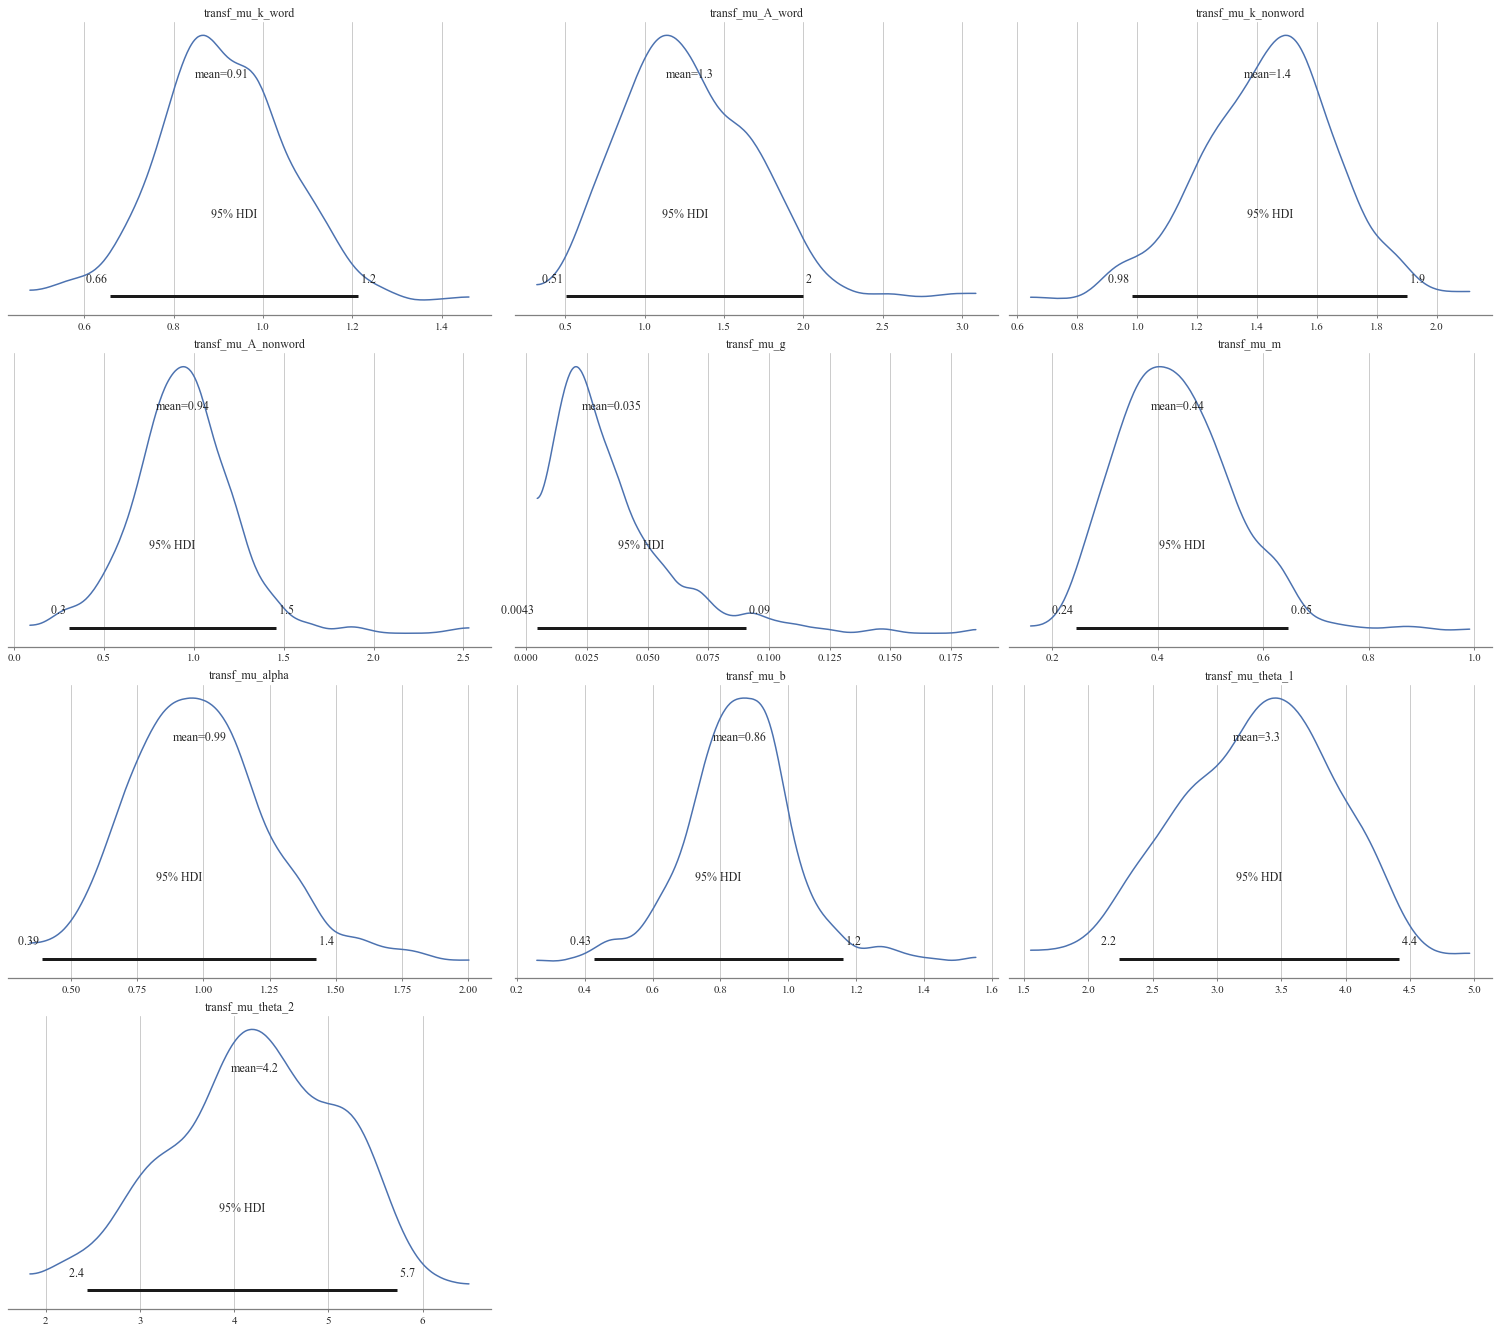

In [32]:
az.plot_posterior(fit, var_names=model_config['transf_params'],
                  hdi_prob=.95);
plt.savefig(plots_path + 'Parameters.pdf')

Loading model parameters for each trial

In [33]:
drift_word_t = fit.stan_variables()['drift_word_t']
drift_nonword_t = fit.stan_variables()['drift_nonword_t']
ndt_t = fit.stan_variables()['ndt_t']
if model_config['model_name'] != "LBA":
    k_t_word = fit.stan_variables()['k_t_word']
    k_t_nonword = fit.stan_variables()['k_t_nonword']
    A_t_word = fit.stan_variables()['A_t_word']
    A_t_nonword = fit.stan_variables()['A_t_nonword']

else:
    k_t = fit.stan_variables()['k_t']
    A_t = fit.stan_variables()['A_t']

#### Models mean parameters in different conditions

In [34]:
v_HF_condition_w = drift_word_t[:, behavioural_df['category']=="HF"]
v_HF_condition_nw = drift_nonword_t[:, behavioural_df['category']=="HF"]
v_LF_condition_w = drift_word_t[:, behavioural_df['category']=="LF"]
v_LF_condition_nw = drift_nonword_t[:, behavioural_df['category']=="LF"]
v_NW_condition_w = drift_word_t[:, behavioural_df['category']=="NW"]
v_NW_condition_nw = drift_nonword_t[:, behavioural_df['category']=="NW"]

In [35]:
print('HF words, word drift mean and std:')
print(np.mean(np.mean(v_HF_condition_w, axis=1)), np.std(np.mean(v_HF_condition_w, axis=1)))
print('HF words, nonword drift mean and std:')
print(np.mean(np.mean(v_HF_condition_nw, axis=1)), np.std(np.mean(v_HF_condition_nw, axis=1)))
print('LF words word drift mean and std:')
print(np.mean(np.mean(v_LF_condition_w, axis=1)), np.std(np.mean(v_LF_condition_w, axis=1)))
print('LF words nonword drift mean and std:')
print(np.mean(np.mean(v_LF_condition_nw, axis=1)), np.std(np.mean(v_LF_condition_nw, axis=1)))
print('NW words word drift mean and std:')
print(np.mean(np.mean(v_NW_condition_w, axis=1)), np.std(np.mean(v_NW_condition_w, axis=1)))
print('NW words nonword drift mean and std:')
print(np.mean(np.mean(v_NW_condition_nw, axis=1)), np.std(np.mean(v_NW_condition_nw, axis=1)))

HF words, word drift mean and std:
4.190770848870523 0.20329539918217077
HF words, nonword drift mean and std:
2.4053214238402205 0.20483550992045005
LF words word drift mean and std:
3.3161663490020366 0.17241832467808654
LF words nonword drift mean and std:
2.3746461232830955 0.20051051422720795
NW words word drift mean and std:
1.478475146250804 0.13781742300487984
NW words nonword drift mean and std:
3.8251436528038583 0.23066046227604695


In [36]:
if model_config['model_name'] != "LBA":
    A_HF_condition_w = A_t_word[:, behavioural_df['category']=="HF"]
    A_HF_condition_nw = A_t_nonword[:, behavioural_df['category']=="HF"]
    A_LF_condition_w = A_t_word[:, behavioural_df['category']=="LF"]
    A_LF_condition_nw = A_t_nonword[:, behavioural_df['category']=="LF"]
    A_NW_condition_w = A_t_word[:, behavioural_df['category']=="NW"]
    A_NW_condition_nw = A_t_nonword[:, behavioural_df['category']=="NW"]
else:
    A_HF_condition = A_t[:, behavioural_df['category']=="HF"]
    A_LF_condition = A_t[:, behavioural_df['category']=="LF"]
    A_NW_condition = A_t[:, behavioural_df['category']=="NW"]

In [37]:
if model_config['model_name'] != "LBA":
    print('HF words, word starting point mean and std:')
    print(np.mean(np.mean(A_HF_condition_w, axis=1)), np.std(np.mean(A_HF_condition_w, axis=1)))
    print('HF words, nonword starting point mean and std:')
    print(np.mean(np.mean(A_HF_condition_nw, axis=1)), np.std(np.mean(A_HF_condition_nw, axis=1)))
    print('LF words word starting point mean and std:')
    print(np.mean(np.mean(A_LF_condition_w, axis=1)), np.std(np.mean(A_LF_condition_w, axis=1)))
    print('LF words nonword starting point mean and std:')
    print(np.mean(np.mean(A_LF_condition_nw, axis=1)), np.std(np.mean(A_LF_condition_nw, axis=1)))
    print('NW words word starting point mean and std:')
    print(np.mean(np.mean(A_NW_condition_w, axis=1)), np.std(np.mean(A_NW_condition_w, axis=1)))
    print('NW words nonword starting point mean and std:')
    print(np.mean(np.mean(A_NW_condition_nw, axis=1)), np.std(np.mean(A_NW_condition_nw, axis=1)))
else:
    print('HF words, starting point mean and std:')
    print(np.mean(np.mean(A_HF_condition, axis=1)), np.std(np.mean(A_HF_condition, axis=1)))
    print('LF words starting point mean and std:')
    print(np.mean(np.mean(A_LF_condition, axis=1)), np.std(np.mean(A_LF_condition, axis=1)))
    print('NW words starting point mean and std:')
    print(np.mean(np.mean(A_NW_condition, axis=1)), np.std(np.mean(A_NW_condition, axis=1)))

HF words, word starting point mean and std:
1.3519989638126721 0.14661239727149755
HF words, nonword starting point mean and std:
0.9359592203756473 0.21138342952671402
LF words word starting point mean and std:
1.3403553960545829 0.14666544503748843
LF words nonword starting point mean and std:
0.9307567087805296 0.2119228594808066
NW words word starting point mean and std:
1.3549993261161846 0.14800585149050072
NW words nonword starting point mean and std:
0.9344293811301604 0.21127798377407347


In [38]:
if model_config['model_name'] != "LBA":
    k_HF_condition_w = k_t_word[:, behavioural_df['category']=="HF"]
    k_HF_condition_nw = k_t_nonword[:, behavioural_df['category']=="HF"]
    k_LF_condition_w = k_t_word[:, behavioural_df['category']=="LF"]
    k_LF_condition_nw = k_t_nonword[:, behavioural_df['category']=="LF"]
    k_NW_condition_w = k_t_word[:, behavioural_df['category']=="NW"]
    k_NW_condition_nw = k_t_nonword[:, behavioural_df['category']=="NW"]

    t_HF_condition_w = A_HF_condition_w + k_HF_condition_w
    t_HF_condition_nw = A_HF_condition_nw + k_HF_condition_nw
    t_LF_condition_w = A_LF_condition_w + k_LF_condition_w
    t_LF_condition_nw = A_LF_condition_nw + k_LF_condition_nw
    t_NW_condition_w = A_NW_condition_w + k_NW_condition_w
    t_NW_condition_nw = A_NW_condition_nw + k_NW_condition_nw
else:
    k_HF_condition = k_t[:, behavioural_df['category']=="HF"]
    k_LF_condition = k_t[:, behavioural_df['category']=="LF"]
    k_NW_condition = k_t[:, behavioural_df['category']=="NW"]

    t_HF_condition = A_HF_condition + k_HF_condition
    t_LF_condition = A_LF_condition + k_LF_condition
    t_NW_condition = A_NW_condition + k_NW_condition

In [39]:
if model_config['model_name'] != "LBA":
    print('HF words, word threshold mean and std:')
    print(np.mean(np.mean(t_HF_condition_w, axis=1)), np.std(np.mean(t_HF_condition_w, axis=1)))
    print('HF words, nonword threshold mean and std:')
    print(np.mean(np.mean(t_HF_condition_nw, axis=1)), np.std(np.mean(t_HF_condition_nw, axis=1)))
    print('LF words word threshold mean and std:')
    print(np.mean(np.mean(t_LF_condition_w, axis=1)), np.std(np.mean(t_LF_condition_w, axis=1)))
    print('LF words nonword threshold mean and std:')
    print(np.mean(np.mean(t_LF_condition_nw, axis=1)), np.std(np.mean(t_LF_condition_nw, axis=1)))
    print('NW words word threshold mean and std:')
    print(np.mean(np.mean(t_NW_condition_w, axis=1)), np.std(np.mean(t_NW_condition_w, axis=1)))
    print('NW words nonword threshold mean and std:')
    print(np.mean(np.mean(t_NW_condition_nw, axis=1)), np.std(np.mean(t_NW_condition_nw, axis=1)))
else:
    print('HF words,  threshold mean and std:')
    print(np.mean(np.mean(t_HF_condition, axis=1)), np.std(np.mean(t_HF_condition, axis=1)))
    print('LF words threshold mean and std:')
    print(np.mean(np.mean(t_LF_condition, axis=1)), np.std(np.mean(t_LF_condition, axis=1)))
    print('NW words word threshold mean and std:')
    print(np.mean(np.mean(t_NW_condition, axis=1)), np.std(np.mean(t_NW_condition, axis=1)))

HF words, word threshold mean and std:
2.263509315256198 0.1561697296045403
HF words, nonword threshold mean and std:
2.450551783356365 0.22631617115210861
LF words word threshold mean and std:
2.2548480095494905 0.1544529404825047
LF words nonword threshold mean and std:
2.4488494825890843 0.2253055896214775
NW words word threshold mean and std:
2.2676491949179 0.15575131271172069
NW words nonword threshold mean and std:
2.449292477425978 0.22488030071104226


In [40]:
if model_config['model_name'] != "LBA":
    bias_HF_condition_w = t_HF_condition_w - A_HF_condition_w
    bias_HF_condition_nw = t_HF_condition_nw - A_HF_condition_nw
    bias_LF_condition_w = t_LF_condition_w - A_LF_condition_w
    bias_LF_condition_nw = t_LF_condition_nw - A_LF_condition_nw
    bias_NW_condition_w = t_NW_condition_w - A_NW_condition_w
    bias_NW_condition_nw = t_NW_condition_nw - A_NW_condition_nw
else:
    bias_HF_condition = t_HF_condition - A_HF_condition
    bias_LF_condition = t_LF_condition - A_LF_condition
    bias_NW_condition = t_NW_condition - A_NW_condition
    bias_NW_condition = t_NW_condition - A_NW_condition

In [41]:
if model_config['model_name'] != "LBA":
    print('HF words, word bias mean and std:')
    print(np.mean(np.mean(bias_HF_condition_w, axis=1)), np.std(np.mean(bias_HF_condition_w, axis=1)))
    print('HF words, nonword bias mean and std:')
    print(np.mean(np.mean(bias_HF_condition_nw, axis=1)), np.std(np.mean(bias_HF_condition_nw, axis=1)))
    print('LF words word bias mean and std:')
    print(np.mean(np.mean(bias_LF_condition_w, axis=1)), np.std(np.mean(bias_LF_condition_w, axis=1)))
    print('LF words nonword bias mean and std:')
    print(np.mean(np.mean(bias_LF_condition_nw, axis=1)), np.std(np.mean(bias_LF_condition_nw, axis=1)))
    print('NW words word bias mean and std:')
    print(np.mean(np.mean(bias_NW_condition_w, axis=1)), np.std(np.mean(bias_NW_condition_w, axis=1)))
    print('NW words nonword bias mean and std:')
    print(np.mean(np.mean(bias_NW_condition_nw, axis=1)), np.std(np.mean(bias_NW_condition_nw, axis=1)))
else:
    print('HF words, bias mean and std:')
    print(np.mean(np.mean(bias_HF_condition, axis=1)), np.std(np.mean(bias_HF_condition, axis=1)))
    print('LF words bias mean and std:')
    print(np.mean(np.mean(bias_LF_condition, axis=1)), np.std(np.mean(bias_LF_condition, axis=1)))
    print('NW words bias mean and std:')
    print(np.mean(np.mean(bias_NW_condition, axis=1)), np.std(np.mean(bias_NW_condition, axis=1)))

HF words, word bias mean and std:
0.911510351443526 0.11591774629836801
HF words, nonword bias mean and std:
1.5145925629807167 0.13713656759497161
LF words word bias mean and std:
0.9144926134949083 0.11594780167859435
LF words nonword bias mean and std:
1.5180927738085543 0.1375741547069401
NW words word bias mean and std:
0.9126498688017141 0.11605274289960162
NW words nonword bias mean and std:
1.5148630962958205 0.13765198783934904


In [42]:
ndt_HF_condition = ndt_t[:, behavioural_df['category']=="HF"]
ndt_LF_condition = ndt_t[:, behavioural_df['category']=="LF"]
ndt_NW_condition = ndt_t[:, behavioural_df['category']=="NW"]

In [43]:
print('HF words ndt mean and std:')
print(np.mean(np.mean(ndt_HF_condition, axis=1)), np.std(np.mean(ndt_HF_condition, axis=1)))
print('LF words ndt mean and std:')
print(np.mean(np.mean(ndt_LF_condition, axis=1)), np.std(np.mean(ndt_LF_condition, axis=1)))
print('Non Words ndt mean and std:')
print(np.mean(np.mean(ndt_NW_condition, axis=1)), np.std(np.mean(ndt_NW_condition, axis=1)))

HF words ndt mean and std:
0.18960590000550961 0.018365961079244344
LF words ndt mean and std:
0.19175926555193487 0.018486395798178762
Non Words ndt mean and std:
0.19732279869453384 0.01912069300479624


## Calculating metrics

In [44]:
def calculate_waic(log_likelihood, pointwise=False):
    """
    Returns model comparisions' metrics.
    
    Parameters
    ----------
        log_likelihood: np.array
            log_likelihood of each trial
        max_rt: float
            maximum acceptable rt
        min_rt: float
             minimum acceptable rt
             
    Optional Parameters
    ----------------
    pointwise: float
        if true pointwise waic will be calculated
        
    Returns
    -------
        out:  a dictionary containing lppd, waic, waic_se and pointwise_waic    
    """
    likelihood = np.exp(log_likelihood)

    mean_l = np.mean(likelihood, axis=0) # N observations

    pointwise_lppd = np.log(mean_l)
    lppd = np.sum(pointwise_lppd)

    pointwise_var_l = np.var(log_likelihood, axis=0) # N observations
    var_l = np.sum(pointwise_var_l)

    pointwise_waic = - 2*pointwise_lppd +  2*pointwise_var_l
    waic = -2*lppd + 2*var_l
    waic_se = np.sqrt(log_likelihood.shape[1] * np.var(pointwise_waic))

    if pointwise:
        out = {'lppd':lppd,
               'p_waic':var_l,
               'waic':waic,
               'waic_se':waic_se,
               'pointwise_waic':pointwise_waic}
    else:
        out = {'lppd':lppd,
               'p_waic':var_l,
                'waic':waic,
                'waic_se':waic_se}
    return out

In [45]:
log_likelihood = fit.stan_variables()['log_lik']
print(calculate_waic(log_likelihood))

{'lppd': 304.48961557761794, 'p_waic': 39.528763085295054, 'waic': -529.9217049846458, 'waic_se': 106.42461509224275}


## Simulating LBA with estimated parameters

In [46]:
def random_lba_2A(k_word, A_word, k_nonword, A_nonword,
                  tau, word_drift, nonword_drift):
    shape = word_drift.shape
    acc = np.empty(shape)
    rt = np.empty(shape)
    acc[:] = np.nan
    rt[:] = np.nan

    b_word = k_word + A_word
    b_nonword = k_nonword + A_nonword
    one_pose = True
    v_word = np.random.normal(word_drift, np.ones(word_drift.shape))
    v_nonword = np.random.normal(nonword_drift, np.ones(nonword_drift.shape))

    while one_pose:
        ind = np.logical_and(v_word < 0, v_nonword < 0)
        v_word[ind] = np.random.normal(word_drift[ind], np.ones(word_drift[ind].shape))
        v_nonword[ind] = np.random.normal(nonword_drift[ind], np.ones(nonword_drift[ind].shape))
        one_pose = np.sum(ind)>0

    start_word = np.random.uniform(np.zeros(A_word.shape), A_word)
    start_nonword = np.random.uniform(np.zeros(A_nonword.shape), A_nonword)

    ttf_word = (b_word - start_word) / v_word
    ttf_nonword = (b_nonword - start_nonword) / v_nonword

    ind = np.logical_and(ttf_word <= ttf_nonword, 0 < ttf_word)
    acc[ind] = 1
    rt[ind] = ttf_word[ind] + tau[ind]

    ind = np.logical_and(ttf_nonword < 0, 0 < ttf_word)
    acc[ind] = 1
    rt[ind] = ttf_word[ind] + tau[ind]

    ind = np.logical_and(ttf_nonword < ttf_word, 0 < ttf_nonword)
    acc[ind] = 0
    rt [ind] = ttf_nonword[ind] + tau[ind]

    ind = np.logical_and(ttf_word < 0, 0 < ttf_nonword)
    acc[ind] = 0
    rt [ind] = ttf_nonword[ind] + tau[ind]

    return rt, acc

Simulating RDM with estimated parameters

In [47]:
if model_config['model_name'] != "LBA":
    pp_rt, pp_response = random_lba_2A(k_t_word, A_t_word, k_t_nonword, A_t_nonword, ndt_t, drift_word_t, drift_nonword_t)
else:
    pp_rt, pp_response = random_lba_2A(k_t, A_t, k_t, A_t, ndt_t, drift_word_t, drift_nonword_t)

In [48]:
def bci(x, alpha=0.05):
    """
    Calculate Bayesian credible interval (BCI).
    
    Parameters
    ----------
    x : array-like
        An array containing MCMC samples.
    
    Optional Parameters
    -------------------
    alpha : float, default 0.05
        Desired probability of type I error.
    
    Returns
    -------
    interval : numpy.ndarray
        Array containing the lower and upper bounds of the bci interval.
    """
    interval = np.nanpercentile(x, [(alpha/2)*100, (1-alpha/2)*100])

    return interval

In [49]:
# Predicted Data
rt_predictions = pd.concat((pd.DataFrame(pp_rt, index=pd.Index(np.arange(1, len(pp_rt)+1))).T, behavioural_df['category']), axis=1)
response_predictions = pd.concat((pd.DataFrame(pp_response, index=pd.Index(np.arange(1, len(pp_response)+1))).T, behavioural_df['category']), axis=1)

# Experiment Data
experiment_data = behavioural_df.loc[:, ['rt', 'response', 'category']]

Separating RT and Response of predicted and experimental data for each condition

In [50]:
HF_data = experiment_data.loc[experiment_data['category']=='HF']
LF_data = experiment_data.loc[experiment_data['category']=='LF']
NW_data = experiment_data.loc[experiment_data['category']=='NW']

HF_pred_rt = rt_predictions.loc[rt_predictions['category']=='HF'].drop(['category'], axis=1)
HF_pred_resp = response_predictions.loc[response_predictions['category']=='HF'].drop(['category'], axis=1)
LF_pred_rt = rt_predictions.loc[rt_predictions['category']=='LF'].drop(['category'], axis=1)
LF_pred_resp = response_predictions.loc[response_predictions['category']=='LF'].drop(['category'], axis=1)
NW_pred_rt = rt_predictions.loc[rt_predictions['category']=='NW'].drop(['category'], axis=1)
NW_pred_resp = response_predictions.loc[response_predictions['category']=='NW'].drop(['category'], axis=1)

## Quantiles Posterior Predictions

In [51]:
quantiles = [.1, .3, .5, .7, .9]
percentiles = np.array(quantiles)*100

In [52]:
# experiment Data quantile
HF_quantile_ex = HF_data['rt'].quantile(quantiles)
LF_quantile_ex = LF_data['rt'].quantile(quantiles)
NW_quantile_ex = NW_data['rt'].quantile(quantiles)

# predicted data quantiles (for each sample)
HF_quantile_pred = HF_pred_rt.quantile(quantiles, axis=0).T
LF_quantile_pred = LF_pred_rt.quantile(quantiles, axis=0).T
NW_quantile_pred = NW_pred_rt.quantile(quantiles, axis=0).T

# predicted data quantiles bci
HF_predicted_bci = np.array([bci(HF_quantile_pred[x]) for x in quantiles])
LF_predicted_bci = np.array([bci(LF_quantile_pred[x]) for x in quantiles])
NW_predicted_bci = np.array([bci(NW_quantile_pred[x]) for x in quantiles])

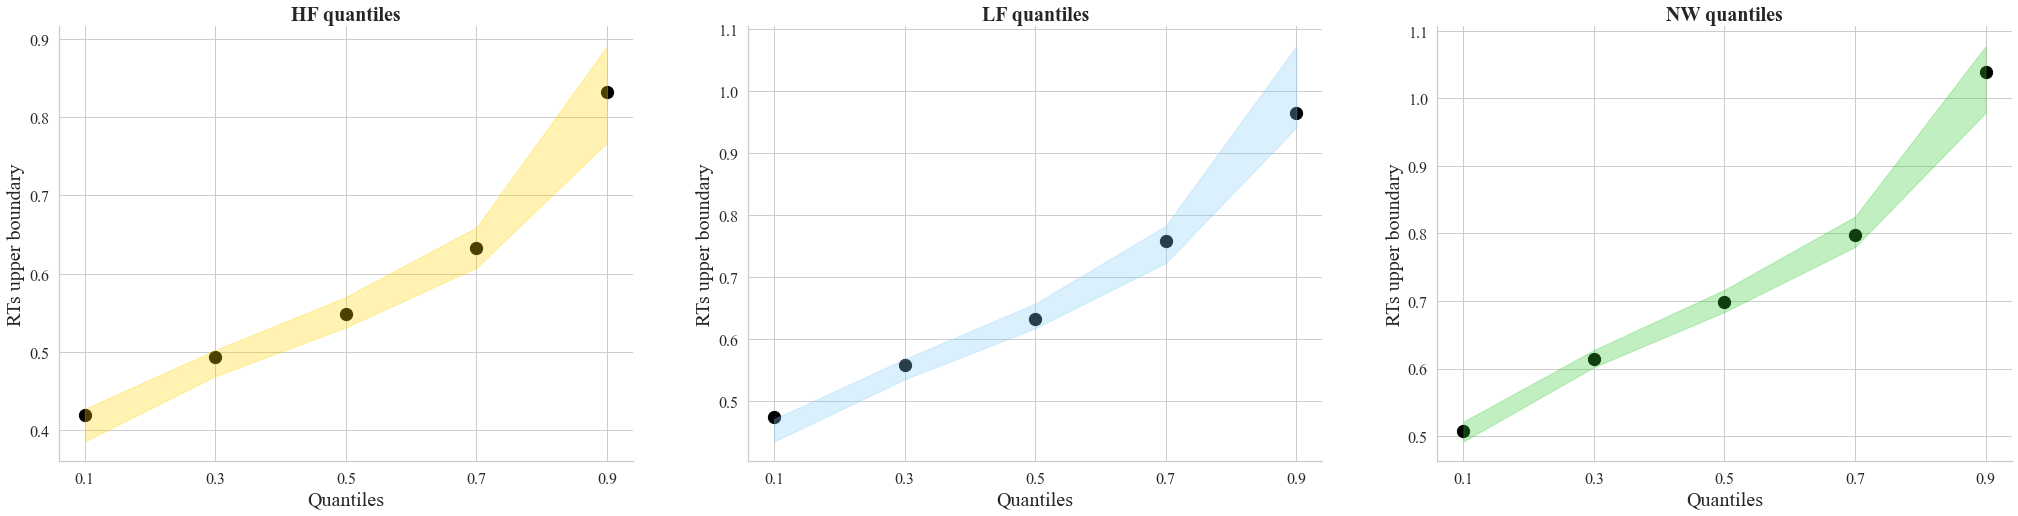

In [53]:
fig, axes = plt.subplots(1,3 , figsize=(35,8))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

axes[0].set_title('HF quantiles', fontweight="bold", size=20)
axes[1].set_title('LF quantiles', fontweight="bold", size=20)
axes[2].set_title('NW quantiles', fontweight="bold", size=20)

axes[0].scatter(quantiles, HF_quantile_ex, color='black', s=150)
axes[1].scatter(quantiles, LF_quantile_ex, color='black', s=150)
axes[2].scatter(quantiles, NW_quantile_ex, color='black', s=150)

axes[0].fill_between(quantiles,
                HF_predicted_bci[:, 0],
                HF_predicted_bci[:, 1],
                HF_predicted_bci[:, 0] < HF_predicted_bci[:, 1],  color = 'gold', alpha=0.3)

axes[1].fill_between(quantiles,
                LF_predicted_bci[:, 0],
                LF_predicted_bci[:, 1],
                LF_predicted_bci[:, 0] < LF_predicted_bci[:, 1],  color = 'lightskyblue', alpha=0.3)

axes[2].fill_between(quantiles,
                NW_predicted_bci[:, 0],
                NW_predicted_bci[:, 1],
                NW_predicted_bci[:, 0] < NW_predicted_bci[:, 1],  color = 'limegreen', alpha=0.3)


for ax in axes:
        ax.set_xlabel('Quantiles', fontsize=20)
        ax.set_xticks(quantiles)
        ax.set_xticklabels(quantiles)
        ax.set_ylabel('RTs upper boundary', fontsize=20)
        for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(16)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(16) 

sns.despine()
plt.savefig(plots_path + 'Quantiles Poseterior.pdf')

## Mean Accuracy and RT Posterior Plots

In [54]:
HF_data_rt_mean = HF_data['rt'].mean()
LF_data_rt_mean = LF_data['rt'].mean()
NW_data_rt_mean = NW_data['rt'].mean()

HF_pred_rt_mean = HF_pred_rt.mean(axis=0)
LF_pred_rt_mean = LF_pred_rt.mean(axis=0)
NW_pred_rt_mean = NW_pred_rt.mean(axis=0)


HF_data_resp_mean = HF_data['response'].mean()
LF_data_resp_mean = LF_data['response'].mean()
NW_data_resp_mean = NW_data['response'].mean()

HF_pred_resp_mean = HF_pred_resp.mean(axis=0)
LF_pred_resp_mean = LF_pred_resp.mean(axis=0)
NW_pred_resp_mean = NW_pred_resp.mean(axis=0)


In [55]:
def plot_posterior(x, data_mean, ax):
    """
    Plots the posterior of x with experimental data mean as a line
    
    Parameters
    ----------
    x : array-like
        An array containing RT or response for each trial.
        
    x : float
        mean of RT or Accuracy of experimental data.

    ax : matplotlib.axes.Axes
        
    Returns
    -------
    None
    """
    density = gaussian_kde(x, bw_method='scott')
    xd = np.linspace(x.min(), x.max())
    yd = density(xd)

    low, high = bci(x)
    ax.fill_between(xd[np.logical_and(xd >= low, xd <= high)],
                     yd[np.logical_and(xd >= low, xd <= high)], color = 'lightsteelblue')

    ax.plot(xd, yd, color='slategray')
    ax.axvline(data_mean, color='red')

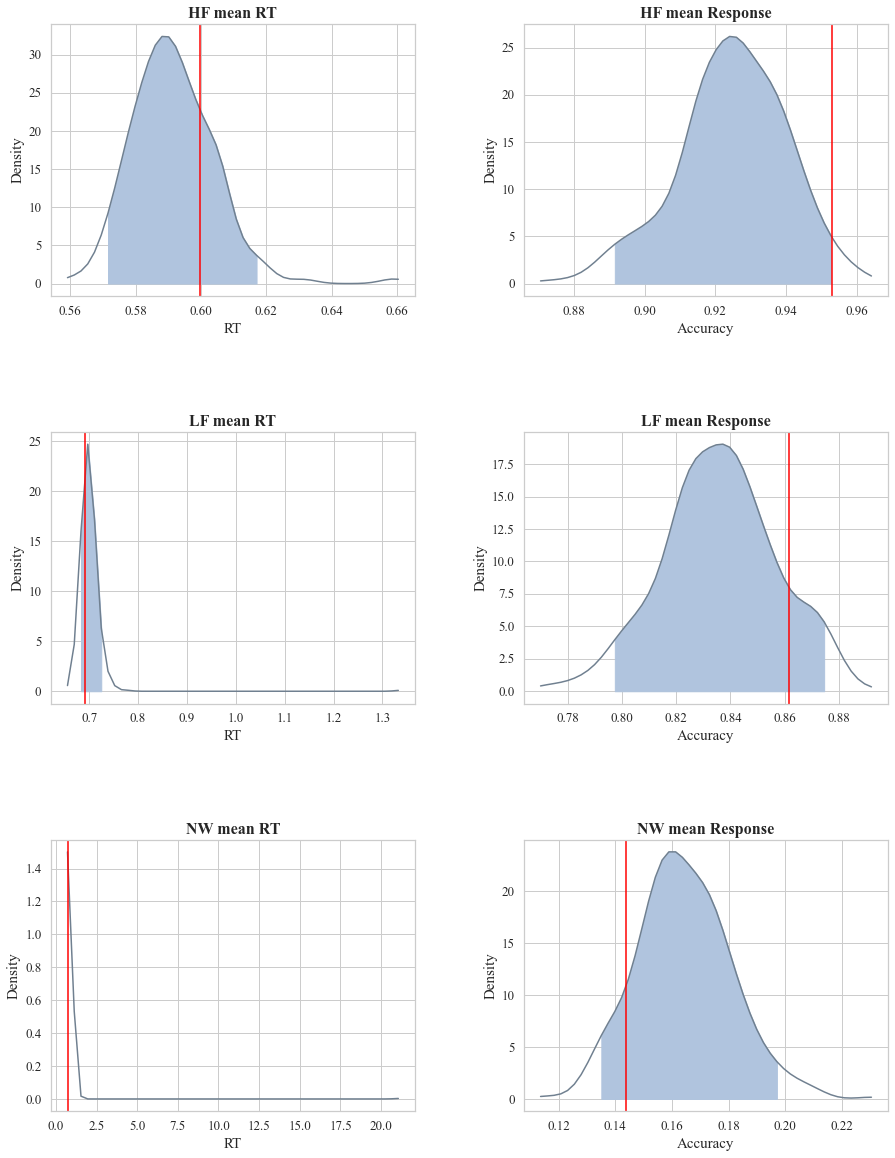

In [56]:
fig, axes = plt.subplots(3,2 , figsize=(15,20))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

axes[0][0].set_title('HF mean RT', fontweight="bold", size=16)
axes[0][1].set_title('HF mean Response', fontweight="bold", size=16)
axes[1][0].set_title('LF mean RT', fontweight="bold", size=16)
axes[1][1].set_title('LF mean Response', fontweight="bold", size=16)
axes[2][0].set_title('NW mean RT', fontweight="bold", size=16)
axes[2][1].set_title('NW mean Response', fontweight="bold", size=16)

plot_posterior(HF_pred_rt_mean, HF_data_rt_mean, axes[0][0])
plot_posterior(HF_pred_resp_mean, HF_data_resp_mean, axes[0][1])

plot_posterior(LF_pred_rt_mean, LF_data_rt_mean, axes[1][0])
plot_posterior(LF_pred_resp_mean, LF_data_resp_mean, axes[1][1])

plot_posterior(NW_pred_rt_mean, NW_data_rt_mean, axes[2][0])
plot_posterior(NW_pred_resp_mean, NW_data_resp_mean, axes[2][1])

for ax in axes:
        ax[0].set_xlabel('RT', fontsize=15)
        ax[1].set_xlabel('Accuracy', fontsize=15)
        ax[0].set_ylabel('Density', fontsize=15)
        ax[1].set_ylabel('Density', fontsize=15)
        for tick in ax[0].xaxis.get_major_ticks():
                tick.label.set_fontsize(13)
        for tick in ax[0].yaxis.get_major_ticks():
            tick.label.set_fontsize(13)
        for tick in ax[1].xaxis.get_major_ticks():
            tick.label.set_fontsize(13)
        for tick in ax[1].yaxis.get_major_ticks():
            tick.label.set_fontsize(13) 

plt.savefig(plots_path + 'Mean Accuracy and RT.pdf')